In [147]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [148]:
import tensorflow as tf
from tensorflow.keras import models,layers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation, Dropout, Flatten, Dense, Input, Resizing, Rescaling, RandomFlip, RandomRotation
import matplotlib.pyplot as plt
import numpy as np
import math

from tensorflow.keras.callbacks import EarlyStopping

# **1. DATASET**

# **#. LOAD, RESIZE**

In [149]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNEL = 3

In [150]:
# load dataset và chia batch. Tương tự ((imgs, labels), ...)
ds = tf.keras.preprocessing.image_dataset_from_directory(
  directory='/content/drive/MyDrive/Colab Notebooks/crop-disease-classification/dataset/Potato',
  seed=123,       # kết quả giống nhau mỗi lần xáo trộn
  shuffle = True,
  image_size=(IMAGE_SIZE,IMAGE_SIZE),  # resize 224x224
  batch_size = BATCH_SIZE,
)

ds

Found 1510 files belonging to 3 classes.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [151]:
total_batch = len(ds)  #tổng số batch: 1510/50
total_batch

48

In [152]:
first_batch = ds.take(1)
len(ds.take(1))

1

1 epoch = tổng số batch = n/batch_size

In [153]:
for images_tf, labels_tf in ds.take(1):
    print("images_tf Shape:", images_tf.shape)  # 4D
    print("labels_tf Shape:", labels_tf.shape)  # 1D
    print("image shape:", images_tf[0].shape)  # 3D
    print("Label numpy:", labels_tf.numpy) # labels_tf.numpy()

images_tf Shape: (32, 224, 224, 3)
labels_tf Shape: (32,)
image shape: (224, 224, 3)
Label numpy: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([0, 1, 1, 1, 0, 2, 2, 2, 2, 0, 2, 1, 1, 0, 1, 2, 1, 1, 0, 0, 1, 1,
       0, 1, 1, 1, 2, 2, 1, 2, 2, 0], dtype=int32)>>


In [154]:
# 3 nhãn
labels = ds.class_names
labels

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

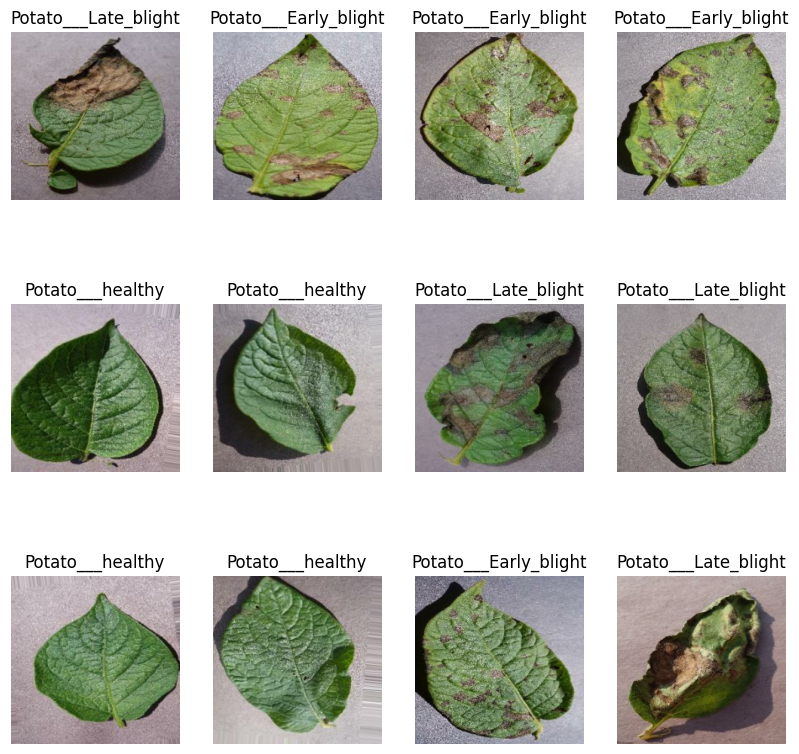

In [155]:
def display_imgs():
  plt.figure(figsize=(10, 10)) #10 inch × 10 inch

  for images_tf, labels_tf in ds.take(1):
      for item in range(12):
          ax = plt.subplot(3, 4, item + 1) # vẽ trục: 3x4, bắt đầu từ ô thứ 1
          plt.imshow(images_tf[item].numpy().astype("uint8"))
          plt.title(labels[labels_tf[item]])
          plt.axis("off")

display_imgs()

# **#. ENCODING**

In [156]:
# one-hot encoding
def encode_one_hot(imgs_tf, labels_tf):
    return (imgs_tf, tf.one_hot(labels_tf, len(ds.class_names)))

ds = ds.map(encode_one_hot)
ds

<_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [157]:
for images_tf, labels_tf in ds.take(1):
    print("Images shape:", images_tf.shape)   # 4D
    print("Labels shape:", labels_tf[:5])   # 2D: (row, column)

Images shape: (32, 224, 224, 3)
Labels shape: tf.Tensor(
[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]], shape=(5, 3), dtype=float32)


# **#. SPLIT**

In [ ]:
def split_dataset (ds, train_split=0.8, val_split=0.15, test_split=0.05, shuffle=True, shuffle_size=10000):
    assert abs(train_split + val_split + test_split - 1.0) < 1e-6

    if shuffle:
      ds = ds.shuffle(shuffle_size, seed=123)

    ds = ds.cache()   # load vào đệm

    train_length = round(len(ds) * train_split)
    val_length = round(len(ds) * val_split)
    test_length = round(len(ds) * test_split)

    ds = ds.enumerate()

    train_ds = (ds.filter(lambda i, _: i < train_length).map(lambda _, batch: batch))
    val_ds = (ds.filter(lambda i, _: train_length <= i < train_length + val_length).map(lambda _, batch: batch))
    test_ds = (ds.filter(lambda i, _: train_length + val_length <= i).map(lambda _, batch: batch))

    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = split_dataset(ds)

# **#. TĂNG CƯỜNG DỮ LIỆU**
-chỉ đc tăng cường cho tập train

In [159]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"), # lật
    layers.RandomRotation(0.2), # xoay
])

# **#. CACHE, SHUFFLE, PREFETCH**

In [160]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# **2. MODEL**

In [161]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNEL)
inputs = Input(shape=input_shape)

res = Rescaling(1./255)(inputs)  # chuẩn hóa giá trị pixel ([0, 255]) về [0, 1]
res = data_augmentation(res, training = True)

# 32 kernel
res = Conv2D(32, (3, 3), activation='relu')(res)
res = MaxPooling2D((2, 2))(res)

res = Conv2D(64, (3, 3), activation='relu')(res)
res = MaxPooling2D((2, 2))(res)

res = Conv2D(64, (3, 3), activation='relu')(res)
res = MaxPooling2D((2, 2))(res)

res = Conv2D(64, (3, 3), activation='relu')(res)
res = MaxPooling2D((2, 2))(res)

res = Conv2D(64, (3, 3), activation='relu')(res)
res = MaxPooling2D((2, 2))(res)

res = Flatten()(res)

# fully-connected, 64 notron
res = Dense(64, activation='relu')(res)

# output-layer: softmax phân loại nhiều lớp
outputs = Dense(len(labels), activation='softmax')(res)  # 3 notron cho 3 lớp

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), # CategoricalCrossentropy cho one-hot label, from_logits=False vì đã sd softmax
    metrics=['accuracy']  # tỷ lệ dự đoán đúng so với tổng số dự đoán
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

# fit và train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=BATCH_SIZE,
    verbose=1,
    epochs=100,
    callbacks=[early_stopping]
)

Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - accuracy: 0.3093 - loss: 1.1062 - val_accuracy: 0.3482 - val_loss: 1.0833
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.4509 - loss: 1.0277 - val_accuracy: 0.7232 - val_loss: 0.5585
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.7567 - loss: 0.5382 - val_accuracy: 0.8839 - val_loss: 0.3184
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.8622 - loss: 0.3251 - val_accuracy: 0.8795 - val_loss: 0.2707
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.8740 - loss: 0.2821 - val_accuracy: 0.9286 - val_loss: 0.1756
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9065 - loss: 0.2288 - val_accuracy: 0.9420 - val_loss: 0.1910
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.9102 - loss: 0.2180 - val_accuracy: 0.8661 - val_loss: 0.3015
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 0.8938 - loss: 0.2614 - val_accuracy: 0

# **3. ĐÁNH GIÁ**

In [173]:
scores = model.evaluate(test_ds)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9909 - loss: 0.0299


In [174]:
print(history.params)
print(history.history.keys())

{'verbose': 1, 'epochs': 100, 'steps': None}
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


In [175]:
history.history['loss'][:5]

[1.0987664461135864,
 0.93351149559021,
 0.4930713176727295,
 0.33099520206451416,
 0.2625451683998108]

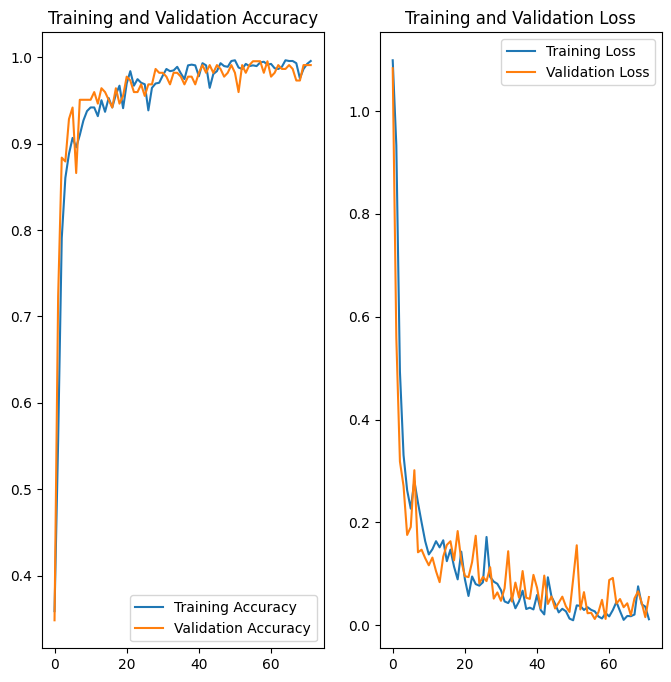

In [176]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(len(acc)), acc, label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(len(loss)), loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

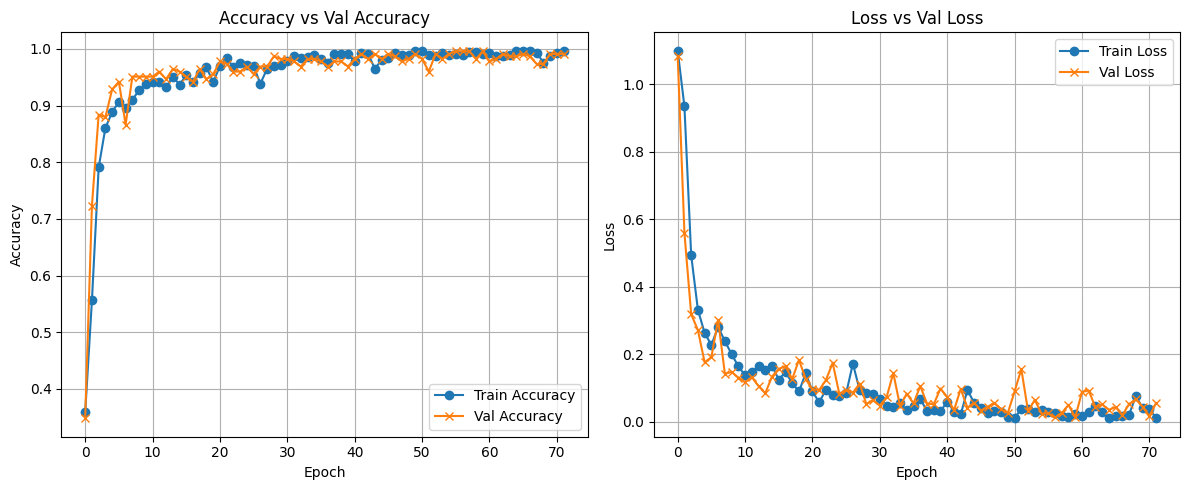

In [177]:
# Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='x')
plt.title('Accuracy vs Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='x')
plt.title('Loss vs Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [178]:
model.save("/content/drive/MyDrive/model/model.h5")

# **4. DỰ ĐOÁN**

In [179]:
model = tf.keras.models.load_model('/content/drive/MyDrive/model/model.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
actual label: Potato___Early_blight
predicted label: Potato___Early_blight


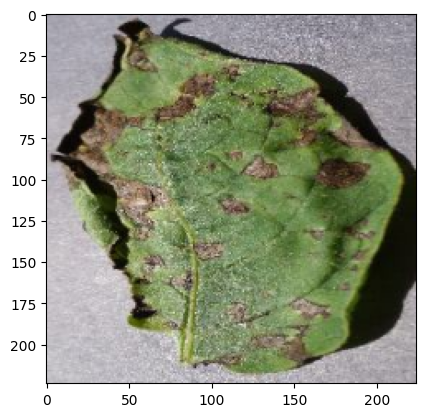

In [180]:
# test
def test_predict():
  for images_tf, labels_tf in test_ds.take(1):
    y_predict = model.predict(images_tf)    # 2D
    print("actual label:", labels[np.argmax(labels_tf[4])])
    print("predicted label:",labels[np.argmax(y_predict[4])])

    plt.imshow(images_tf[4].numpy().astype("uint8"))

test_predict()

In [181]:
def display(y_predict):
    for i in range(9):
        print(y_predict[i])

        actual_label = labels[np.argmax(labels_tf[i])]

        predicted_label = labels[np.argmax(y_predict[i])]  # lấy chỉ mục của giá trị lớn nhất

        predicted_score = round(np.max(y_predict[i]) * 100, 2) # chuyển về %

        ax = plt.subplot(3, 3, i + 1)
        plt.title(f"Actual: {actual_label},\n Predicted: {predicted_label}.\n predicted_score: {predicted_score}%")
        plt.axis("off")
        plt.imshow(images_tf[i].numpy().astype("uint8"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
[1.0783044e-12 5.3973363e-06 9.9999464e-01]
[5.5419648e-11 2.8649820e-05 9.9997139e-01]
[9.9999917e-01 7.8259336e-07 2.7435712e-13]
[2.9349264e-02 9.7065073e-01 1.0270204e-14]
[9.9999976e-01 2.4831354e-07 3.2412640e-24]
[9.9999952e-01 4.2273277e-07 3.6065070e-14]
[9.9993134e-01 6.8642650e-05 3.8242383e-09]
[1.0000000e+00 8.5114873e-11 5.8471347e-25]
[9.9999845e-01 1.5578283e-06 5.4662724e-12]


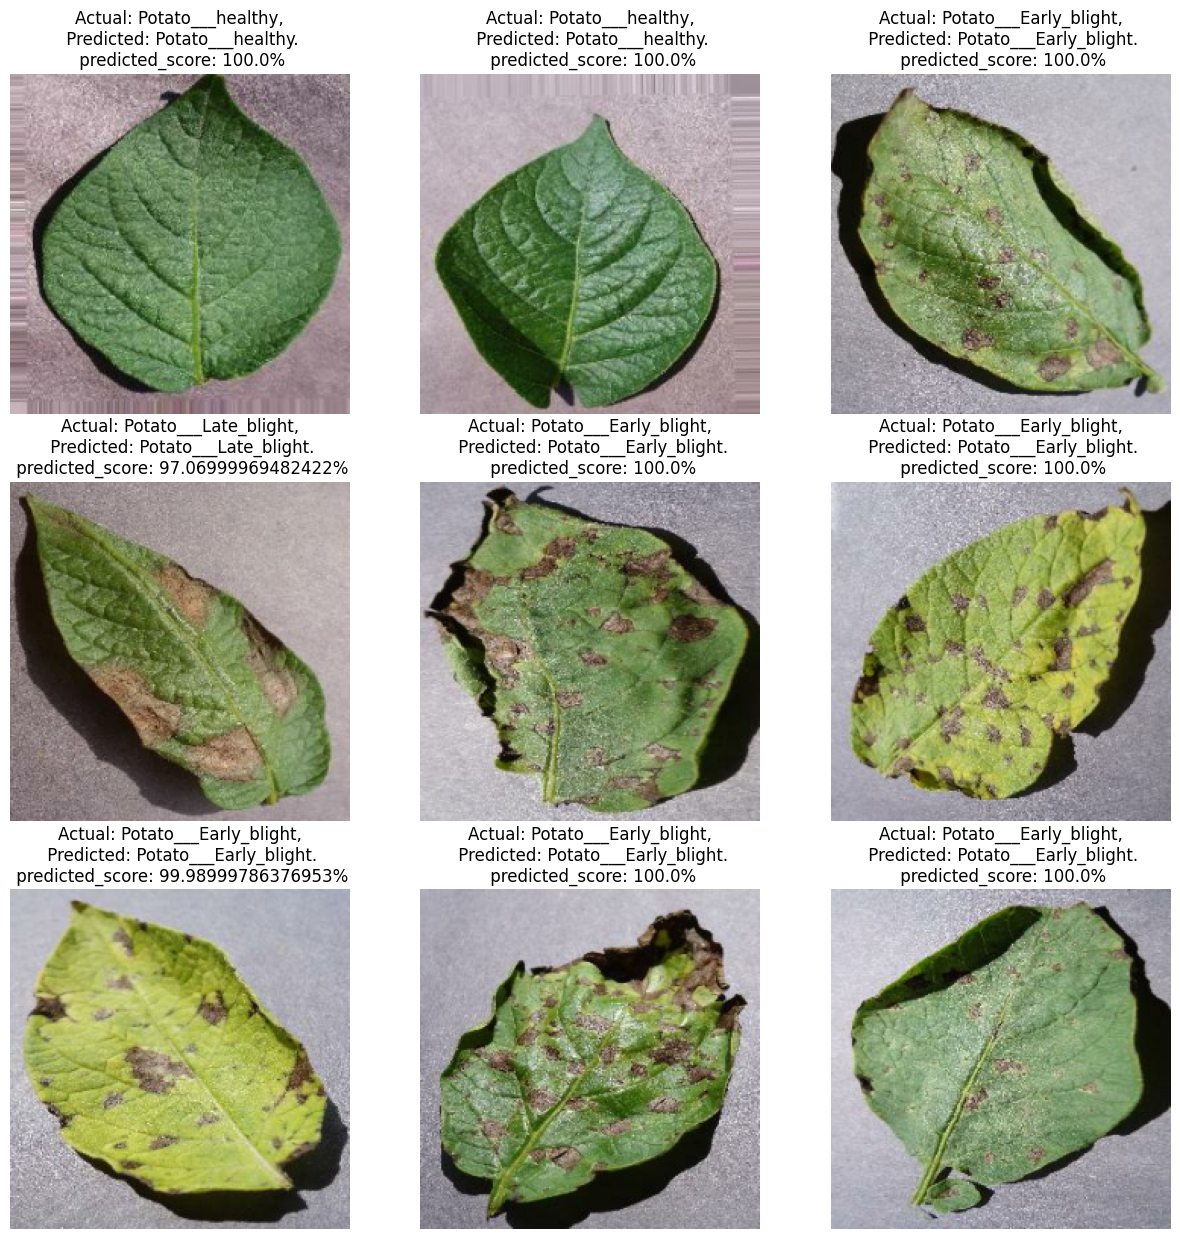

In [182]:
plt.figure(figsize=(15, 15))

for images_tf, labels_tf in test_ds.take(1):
    y_predict = model.predict(images_tf) # 2D
    display(y_predict)